##  [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/)

#### The aim of this project was to implement convolutional neural network to predict german traffic sign based on photos.

In [1]:
import tensorflow as tf
import pickle

import numpy as np
import pandas as pd
np.random.seed(2019)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
import livelossplot

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
%matplotlib inline

from skimage import color, exposure
from sklearn.model_selection import train_test_split
from collections import Counter

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Loading data

In [2]:
training_file = "train.p"
test_file     = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f) 
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print(X_train.shape, X_test.shape)

(34799, 32, 32, 3) (4410, 32, 32, 3)


In [3]:
signnames = pd.read_csv('signnames.csv')
signnames.head()

,a,b
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [4]:
traffic_labels_dict = signnames[ ['b'] ].to_dict()['b']
traffic_labels_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

### Examples of each sign

Speed limit (20km/h)


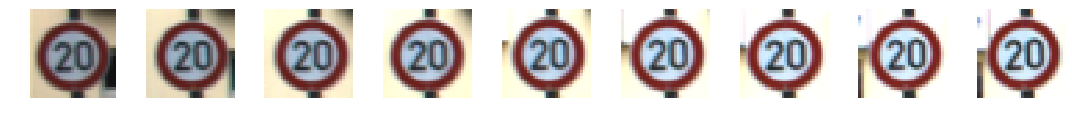

Speed limit (30km/h)


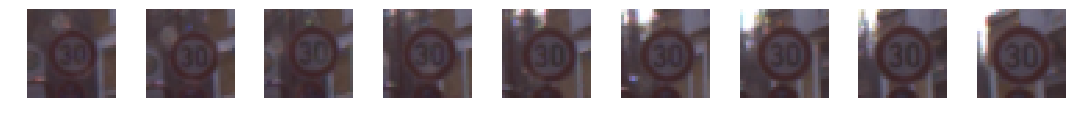

Speed limit (50km/h)


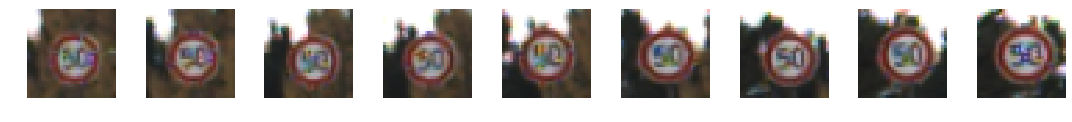

Speed limit (60km/h)


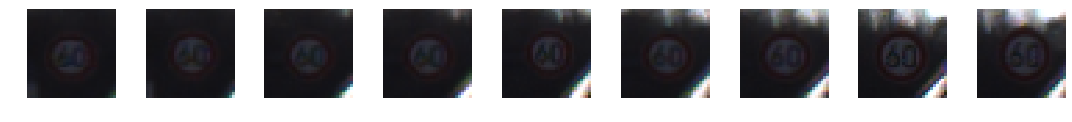

Speed limit (70km/h)


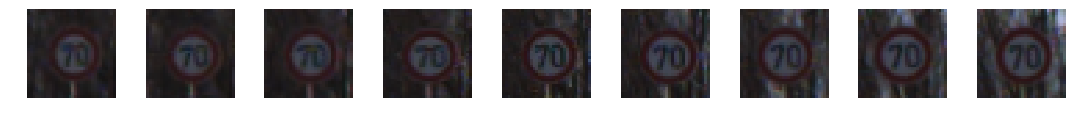

Speed limit (80km/h)


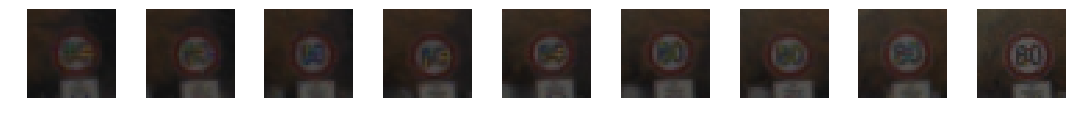

End of speed limit (80km/h)


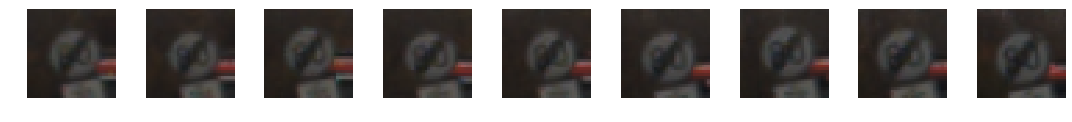

Speed limit (100km/h)


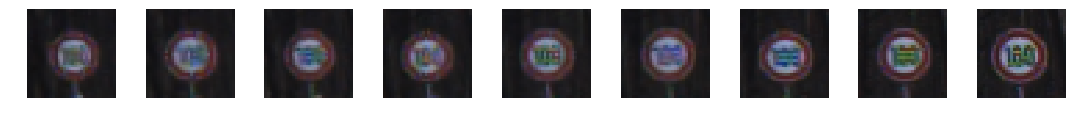

Speed limit (120km/h)


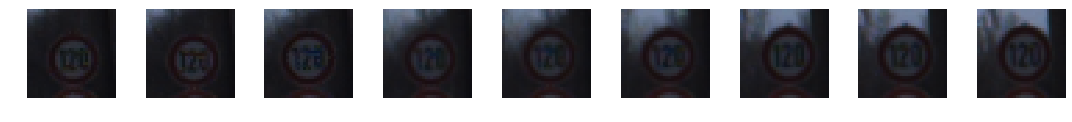

No passing


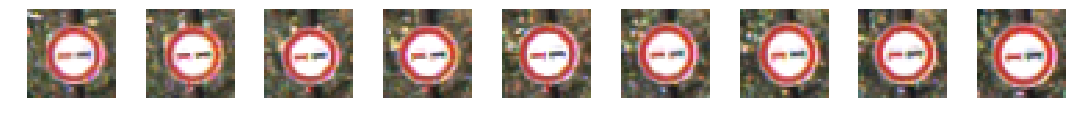

No passing for vehicles over 3.5 metric tons


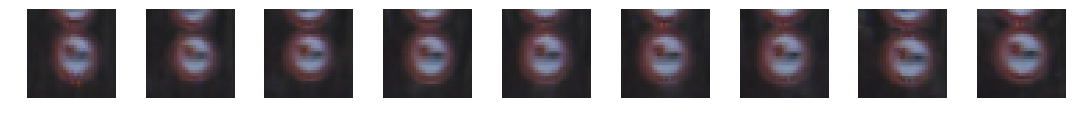

Right-of-way at the next intersection


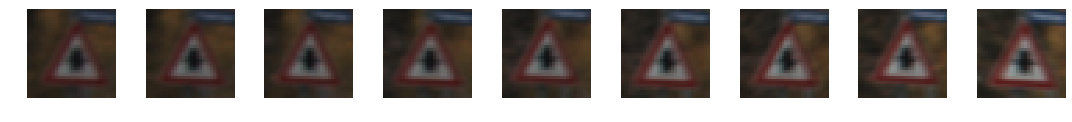

Priority road


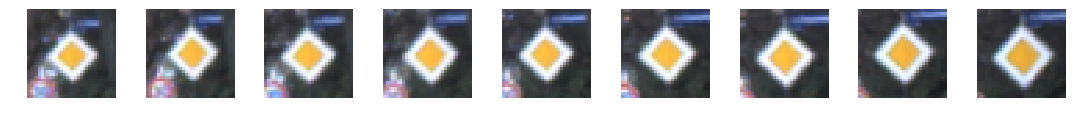

Yield


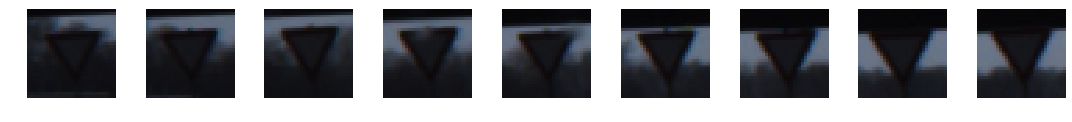

Stop


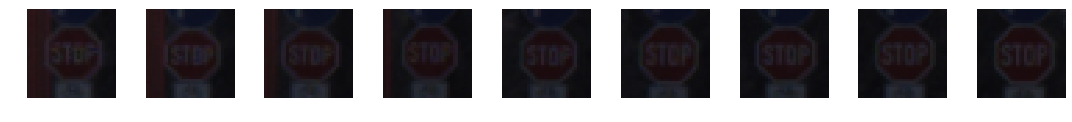

No vehicles


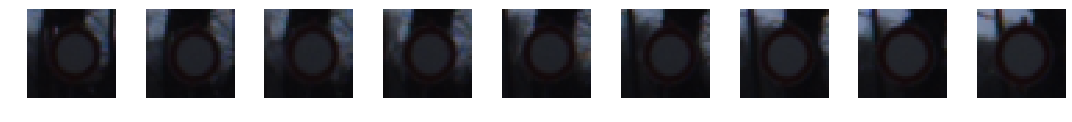

Vehicles over 3.5 metric tons prohibited


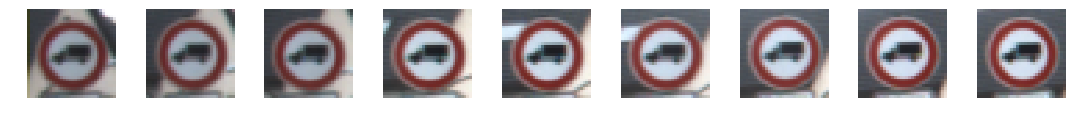

No entry


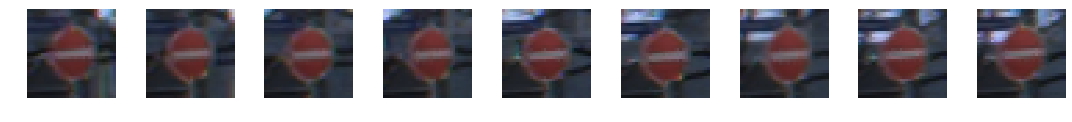

General caution


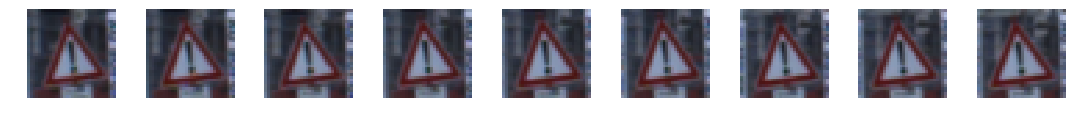

Dangerous curve to the left


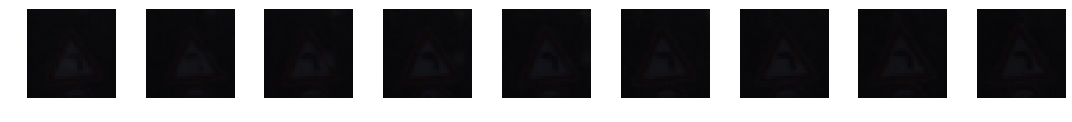

Dangerous curve to the right


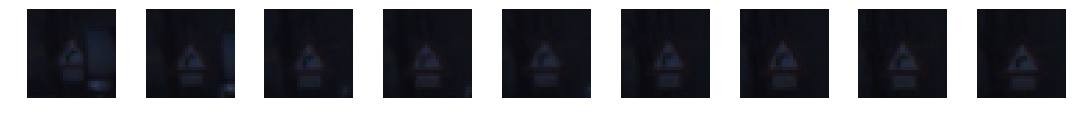

Double curve


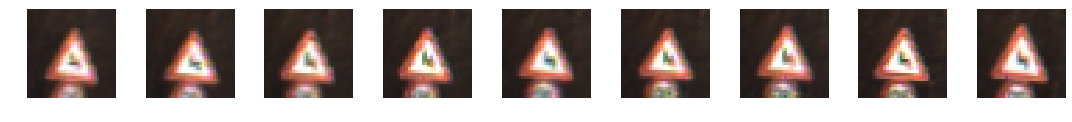

Bumpy road


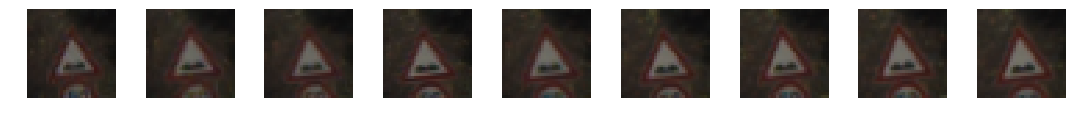

Slippery road


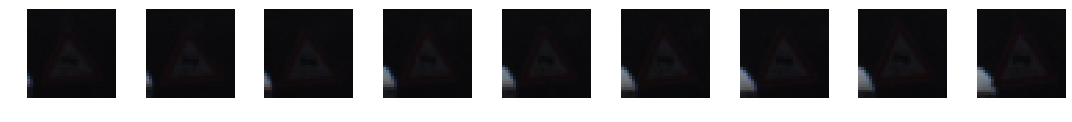

Road narrows on the right


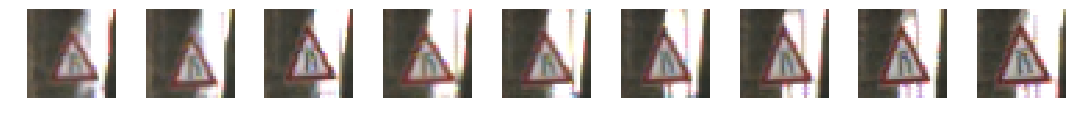

Road work


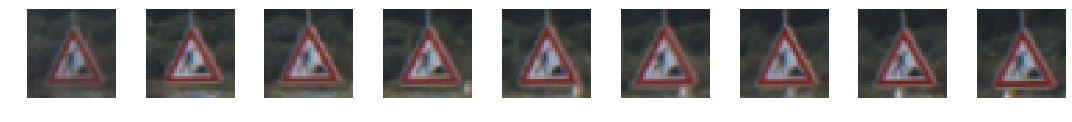

Traffic signals


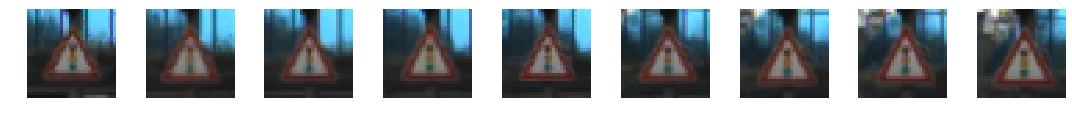

Pedestrians


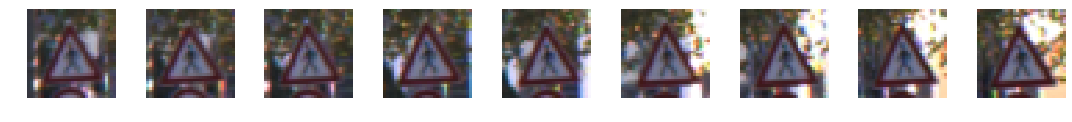

Children crossing


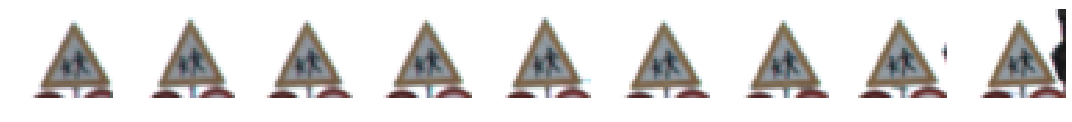

Bicycles crossing


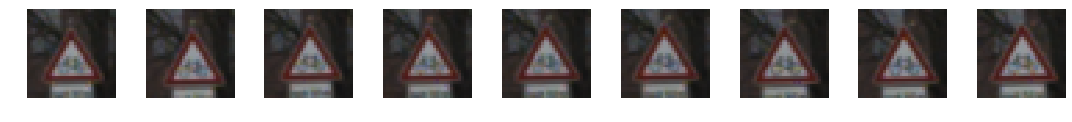

Beware of ice/snow


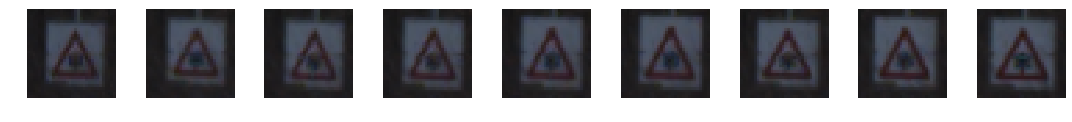

Wild animals crossing


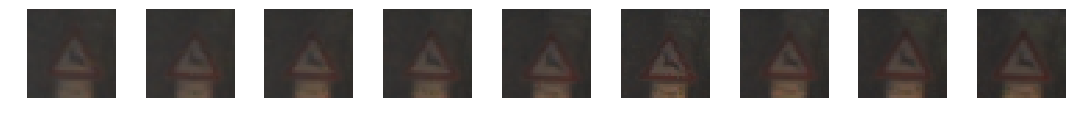

End of all speed and passing limits


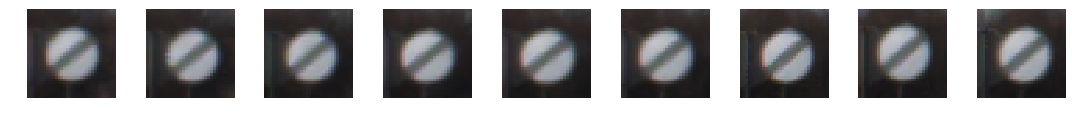

Turn right ahead


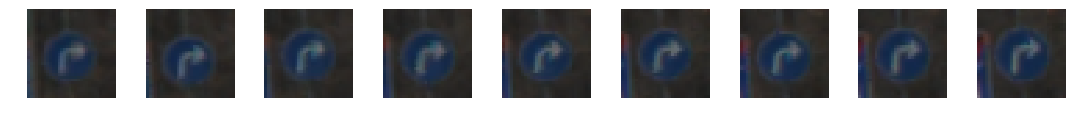

Turn left ahead


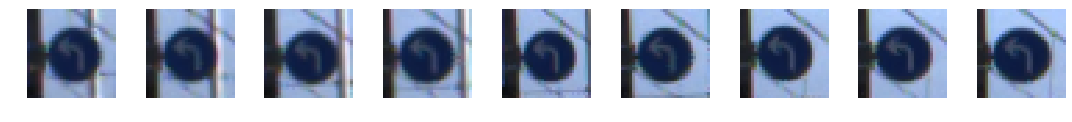

Ahead only


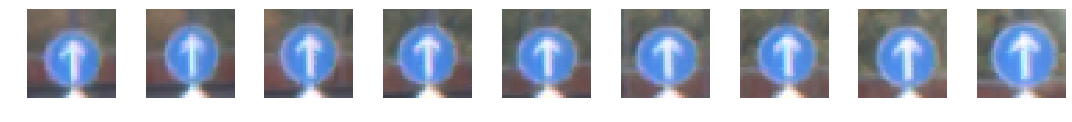

Go straight or right


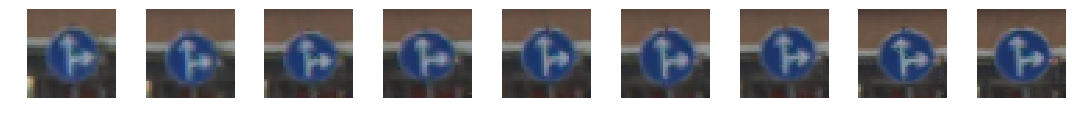

Go straight or left


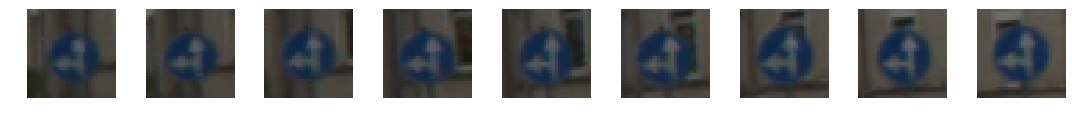

Keep right


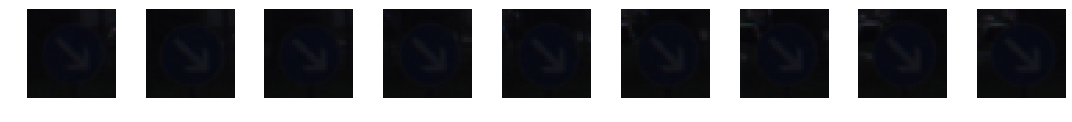

Keep left


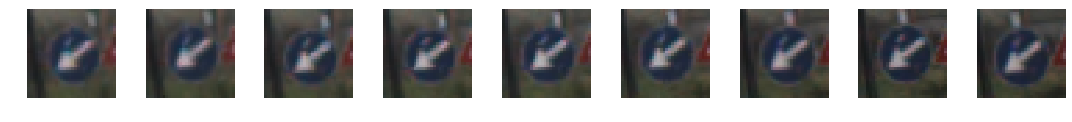

Roundabout mandatory


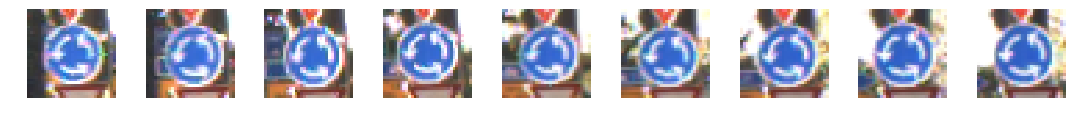

End of no passing


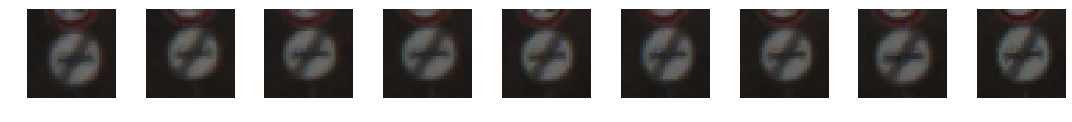

End of no passing by vehicles over 3.5 metric tons


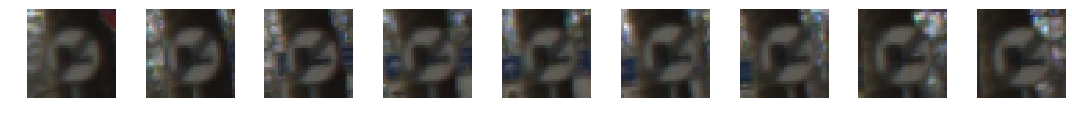

In [5]:
for sign_id in traffic_labels_dict.keys():
    print(traffic_labels_dict[sign_id])
    signs = X_train[ y_train == sign_id ] 
    plt.figure(figsize=(15, 12))
    
    for idx in range(9):
        plt.subplot("19{0}".format(1 + idx) )
        plt.imshow( signs[idx,])
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

### Distribution of target variable

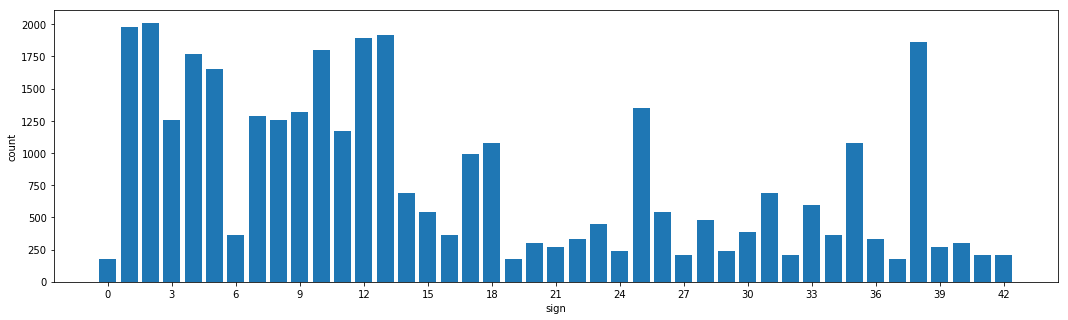

In [5]:
cnt = Counter(y_train)
plt.figure(figsize=(18, 5))
plt.bar(list(cnt.keys()),list(cnt.values()))

plt.xlabel('sign')
plt.xticks(range(0,43,3))
plt.ylabel('count')
plt.show()

In [8]:
med = np.median(list(cnt.values()))
for k, v in cnt.items():
    if v < med:
        print(k, ' ', med-v)

41   330.0
36   210.0
23   90.0
40   240.0
22   210.0
37   360.0
16   180.0
19   360.0
42   330.0
0   360.0
32   330.0
27   330.0
29   300.0
24   300.0
34   180.0
6   180.0
30   150.0
39   270.0
21   270.0
20   240.0
28   60.0


For some categories the number of photos is much smaller than median.

### Convolutional neural network models
Initial model has been built using Keras 

In [6]:
X_train, y_train = train['features'], train['labels']
X_t, y_t = test['features'], test['labels']
X_test, X_valid, y_test, y_valid = train_test_split(X_t, y_t, test_size=0.5, random_state=2018) 

In [7]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)    
if y_valid.ndim == 1: y_valid = to_categorical(y_valid)    
    
input_shape = X_train.shape[1:]
num_classes = len(traffic_labels_dict)

In [9]:
def get_doubled_cnn3_with_dropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),         
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
model = get_doubled_cnn3_with_dropout()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
__________

### Training

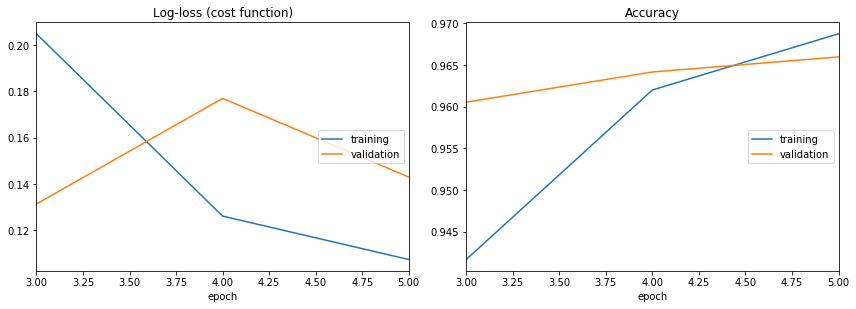

Log-loss (cost function):
training   (min:    0.107, max:    2.405, cur:    0.107)
validation (min:    0.131, max:    0.641, cur:    0.143)

Accuracy:
training   (min:    0.382, max:    0.969, cur:    0.969)
validation (min:    0.836, max:    0.966, cur:    0.966)


In [10]:
plot_losses = livelossplot.PlotLossesKeras()

history = model.fit(X_train, y_train,
                  batch_size=128,
                  epochs=5,
                  verbose=1,
                  callbacks=[plot_losses],
                  validation_data=(X_test, y_test))

In [11]:
def draw_learning_curve(history, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(13,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

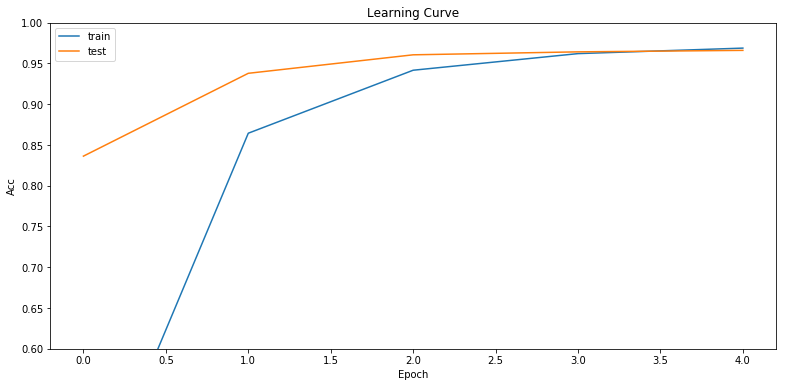

In [12]:
draw_learning_curve(history, key='acc', ylim=(0.6, 1.))

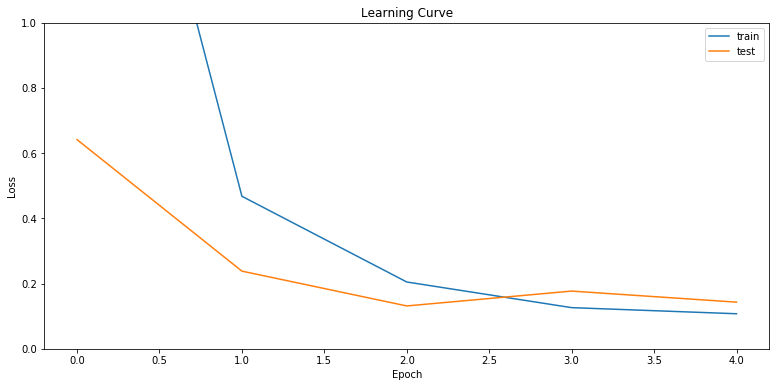

In [13]:
draw_learning_curve(history, key='loss', ylim=(0., 1.))

#### Testing using validation data

In [14]:
score = model.evaluate(X_valid, y_valid, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.1627297780444833
Test accuracy: 0.9632653058791647
CNN Error: 3.67%


### Tensorflow implementation with early stopping

In [5]:
X_train, y_train = train['features'], train['labels']
X_t, y_t = test['features'], test['labels']
X_test, X_valid, y_test, y_valid = train_test_split(X_t, y_t, test_size=0.5, random_state=2018) 

In [7]:
height = X_train.shape[1]
width = X_train.shape[2]
channels = X_train.shape[3]
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_dropout_rate = 0.2
pool1_fmaps = conv1_fmaps

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_dropout_rate = 0.2
pool2_fmaps = conv2_fmaps

conv3_fmaps = 128
conv3_ksize = 3
conv3_stride = 1
conv3_dropout_rate = 0.2
pool3_fmaps = conv3_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.2

n_outputs = len(traffic_labels_dict)

tf.reset_default_graph()
with tf.name_scope("input"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='learn')

with tf.name_scope("c1"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",activation=tf.nn.relu, name="splot1")
    conv2 = tf.layers.conv2d(conv1, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="VALID",activation=tf.nn.relu, name="splot2")
    pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool1_drop = tf.layers.dropout(pool1, conv1_dropout_rate, training=training)

with tf.name_scope("c2"):
    conv3 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",activation=tf.nn.relu, name="splot3")
    conv4 = tf.layers.conv2d(conv3, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="VALID",activation=tf.nn.relu, name="splot4")
    pool2 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool1_drop = tf.layers.dropout(pool2, conv2_dropout_rate, training=training)

with tf.name_scope("c3"):
    conv5 = tf.layers.conv2d(pool2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",activation=tf.nn.relu, name="splot5")
    conv6 = tf.layers.conv2d(conv5, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="VALID", activation=tf.nn.relu, name="splot6")
    pool3 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat=tf.contrib.layers.flatten(pool3)
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv3_dropout_rate, training=training)

with tf.name_scope("dense"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="dense")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_prob")

with tf.name_scope("learn"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [8]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [9]:
def next_batch(x_= X_train, y_= y_train,batch_size=300, batch_index=2, epocha=1):
    tf.set_random_seed(epocha*len(x_)//batch_size + batch_index)
    np.random.seed(epocha*len(x_)//batch_size + batch_index)
    
    indices = np.random.randint(len(x_), size=batch_size) 
    np.random.shuffle(indices)
    return x_[indices], y_[indices]

In [10]:
n_epochs = 20
batch_s = 128

best_loss_val = np.infty
checks_since_last_progress = 0
max_checks_without_progress = 5
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(X_train.shape[0] // batch_s):
            X_batch, y_batch = next_batch(batch_index=iteration, epocha=epoch, batch_size=batch_s)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        loss_val = loss.eval(feed_dict={X: X_test, y: y_test})
        if loss_val < best_loss_val:
            best_loss_val = loss_val
            checks_since_last_progress = 0
            best_model_params = get_model_params()
        else:
            checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch {}, train accuracy {:.4f}%, loss {:.4f}".format(epoch+1, acc_train * 100, loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping")
            break
            
    if best_model_params:
        restore_model_params(best_model_params)
    acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
    print("Validation error: {:.2f}%".format(100-acc_val*100))
    save_path = saver.save(sess, "./sign_tf_model")

Epoch 1, train accuracy 90.0680%, loss 0.4634
Epoch 2, train accuracy 91.8821%, loss 0.4513
Epoch 3, train accuracy 95.3288%, loss 0.2068
Epoch 4, train accuracy 96.1451%, loss 0.2384
Epoch 5, train accuracy 97.4150%, loss 0.2287
Epoch 6, train accuracy 94.7846%, loss 0.2910
Epoch 7, train accuracy 95.8277%, loss 0.3400
Epoch 8, train accuracy 96.2812%, loss 0.3085
Epoch 9, train accuracy 97.4603%, loss 0.1859
Epoch 10, train accuracy 96.1451%, loss 0.2745
Epoch 11, train accuracy 95.5556%, loss 0.2474
Epoch 12, train accuracy 96.5079%, loss 0.1885
Epoch 13, train accuracy 96.5986%, loss 0.1754
Epoch 14, train accuracy 97.6417%, loss 0.1348
Epoch 15, train accuracy 97.5510%, loss 0.2054
Epoch 16, train accuracy 97.2336%, loss 0.1753
Epoch 17, train accuracy 97.7778%, loss 0.2471
Epoch 18, train accuracy 97.2336%, loss 0.1702
Epoch 19, train accuracy 96.0998%, loss 0.2449
Epoch 20, train accuracy 97.5964%, loss 0.1301
Validation error: 2.49%


### Data transformation

Some transformations have been applied in order to check infuence on model.

In [6]:
def preproc_img(img):
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_adapthist(hsv[:, :, 2])
    img = color.hsv2rgb(img)
    return img

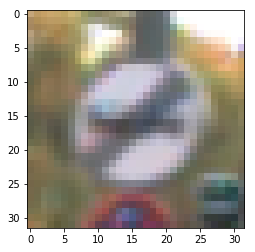

In [22]:
plt.imshow(X_train[100])

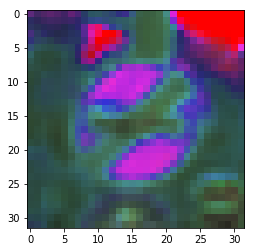

In [23]:
plt.imshow(preproc_img(X_train[100]))

In [9]:
X_train_prp = X_train.copy().astype(np.float32)

for i in tqdm(range(X_train.shape[0])):
    X_train_prp[i] = preproc_img(X_train[i])

100%|██████████| 34799/34799 [06:40<00:00, 86.97it/s]


In [7]:
X_test_prp = X_test.copy().astype(np.float32)

for i in tqdm(range(X_test.shape[0])):
    X_test_prp[i] = preproc_img(X_test[i])

100%|██████████| 2205/2205 [00:30<00:00, 71.34it/s]


In [8]:
X_valid_prp = X_valid.copy().astype(np.float32)

for i in tqdm(range(X_valid.shape[0])):
    X_valid_prp[i] = preproc_img(X_valid[i])

100%|██████████| 2205/2205 [00:25<00:00, 84.70it/s]


In [15]:
height = X_train_prp.shape[1]
width = X_train_prp.shape[2]
channels = X_train_prp.shape[3]
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_dropout_rate = 0.2
pool1_fmaps = conv1_fmaps

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_dropout_rate = 0.2
pool2_fmaps = conv2_fmaps

conv3_fmaps = 128
conv3_ksize = 3
conv3_stride = 1
conv3_dropout_rate = 0.2
pool3_fmaps = conv3_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.2

n_outputs = len(traffic_labels_dict)

tf.reset_default_graph()
with tf.name_scope("input"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='lerning')

with tf.name_scope("c1"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",activation=tf.nn.relu, name="splot1")
    conv2 = tf.layers.conv2d(conv1, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="VALID",activation=tf.nn.relu, name="splot2")
    pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool1_drop = tf.layers.dropout(pool1, conv1_dropout_rate, training=training)

with tf.name_scope("c2"):
    conv3 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",activation=tf.nn.relu, name="splot3")
    conv4 = tf.layers.conv2d(conv3, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="VALID",activation=tf.nn.relu, name="splot4")
    pool2 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool1_drop = tf.layers.dropout(pool2, conv2_dropout_rate, training=training)

with tf.name_scope("c3"):
    conv5 = tf.layers.conv2d(pool2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",activation=tf.nn.relu, name="splot5")
    conv6 = tf.layers.conv2d(conv5, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="VALID", activation=tf.nn.relu, name="splot6")
    pool3 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat=tf.contrib.layers.flatten(pool3)
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv3_dropout_rate, training=training)

with tf.name_scope("pp1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="pp1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_prop")

with tf.name_scope("learn"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [16]:
n_epochs = 20
batch_s = 128

best_loss_val = np.infty
checks_since_last_progress = 0
max_checks_without_progress = 5
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(X_train_prp.shape[0] // batch_s):
            X_batch, y_batch = next_batch(x_= X_train_prp, y_= y_train, batch_index=iteration, 
                                          epocha=epoch, batch_size=batch_s)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        loss_val = loss.eval(feed_dict={X: X_test_prp, y: y_test})
        if loss_val < best_loss_val:
            best_loss_val = loss_val
            checks_since_last_progress = 0
            best_model_params = get_model_params()
        else:
            checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_test_prp, y: y_test})
        print("Epoch {}, train accuracy {:.4f}%, loss {:.4f}".format(epoch+1, acc_train * 100,loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping")
            break
    if best_model_params:
        restore_model_params(best_model_params)
    acc_val = accuracy.eval(feed_dict={X: X_valid_prp, y: y_valid})
    print("Validation error: {:.2f}%".format(100-acc_val*100))
    save_path = saver.save(sess, "./sign_tf_model_tr")

Epoch 1, train accuracy 81.3605%, loss 0.6620
Epoch 2, train accuracy 92.1995%, loss 0.3100
Epoch 3, train accuracy 93.4240%, loss 0.2326
Epoch 4, train accuracy 93.1519%, loss 0.2706
Epoch 5, train accuracy 95.1474%, loss 0.2089
Epoch 6, train accuracy 95.0567%, loss 0.2081
Epoch 7, train accuracy 96.4172%, loss 0.1925
Epoch 8, train accuracy 93.5601%, loss 0.3294
Epoch 9, train accuracy 95.9184%, loss 0.1596
Epoch 10, train accuracy 94.4671%, loss 0.2298
Epoch 11, train accuracy 95.2834%, loss 0.2354
Epoch 12, train accuracy 94.9660%, loss 0.2292
Epoch 13, train accuracy 96.1905%, loss 0.1500
Epoch 14, train accuracy 95.6463%, loss 0.1906
Epoch 15, train accuracy 95.5102%, loss 0.3011
Epoch 16, train accuracy 96.5986%, loss 0.2183
Epoch 17, train accuracy 96.8708%, loss 0.2286
Epoch 18, train accuracy 95.6916%, loss 0.2607
Epoch 19, train accuracy 96.0998%, loss 0.2023
Early stopping
Validation error: 4.58%


Data transformation don't have significant impact on result in this case.

###  Data augmentation 

Another experiment was performed by generating additional data for classes with small number of examples. Classes with low quality of pictures have been modified by flip transformation.

In [27]:
X_train, y_train = train['features'], train['labels']
X_t, y_t = test['features'], test['labels']
X_test, X_valid, y_test, y_valid = train_test_split(X_t, y_t, test_size=0.5, random_state=2018) 

In [28]:
from scipy.misc import imresize

def prepare_image(image, target_width = 32, target_height = 32, max_zoom = 0.2):
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    image = image[y0:y1, x0:x1]
    image = imresize(image, (target_width, target_height))    
    return image

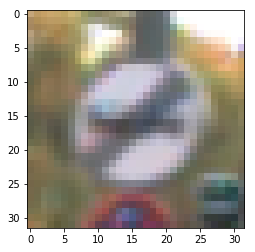

In [29]:
plt.imshow(X_train[100])

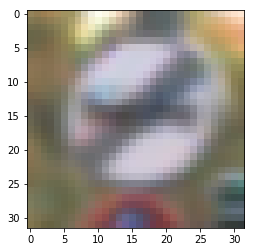

In [30]:
plt.imshow(prepare_image(X_train[100]))

In [31]:
tx = []
ty = []

for i, j in enumerate(list(y_train)):
    if j==20:
        tx.append(np.fliplr(X_train[i]) )
        ty.append(19)
    if j==39:
        tx.append(np.fliplr(X_train[i]) )
        ty.append(38)  

In [32]:
cnt = Counter(y_train)
med = np.median(list(cnt.values()))

for i, j in enumerate(list(y_train)):
    if cnt[j] < med:
        tx.append(prepare_image(X_train[i]))
        ty.append(j)       
X_proc = np.concatenate((X_train[(y_train!=19) & (y_train!=38)], np.array(tx)))
y_proc = np.concatenate((y_train[(y_train!=19) & (y_train!=38)], np.array(ty)))

print(X_proc.shape, y_proc.shape)

(39389, 32, 32, 3) (39389,)


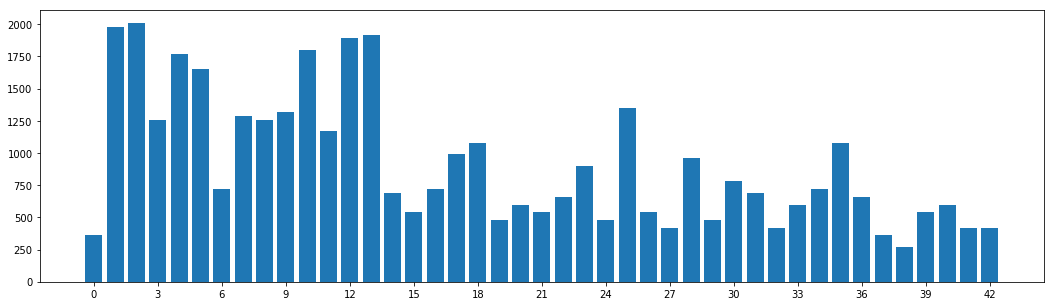

In [33]:
cnt2 = Counter(y_proc)

plt.figure(figsize=(18, 5))
plt.bar(list(cnt2.keys()), list(cnt2.values()))
plt.xticks(range(0,43,3))
plt.show()

In [36]:
height = X_proc.shape[1]
width = X_proc.shape[2]
channels = X_proc.shape[3]
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_dropout_rate = 0.2
pool1_fmaps = conv1_fmaps

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_dropout_rate = 0.2
pool2_fmaps = conv2_fmaps

conv3_fmaps = 128
conv3_ksize = 3
conv3_stride = 1
conv3_dropout_rate = 0.2
pool3_fmaps = conv3_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.2

n_outputs = len(traffic_labels_dict)

tf.reset_default_graph()
with tf.name_scope("input"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='lerning')

with tf.name_scope("c1"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="SAME",activation=tf.nn.relu, name="splot1")
    conv2 = tf.layers.conv2d(conv1, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding="VALID",activation=tf.nn.relu, name="splot2")
    pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool1_drop = tf.layers.dropout(pool1, conv1_dropout_rate, training=training)

with tf.name_scope("c2"):
    conv3 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="SAME",activation=tf.nn.relu, name="splot3")
    conv4 = tf.layers.conv2d(conv3, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding="VALID",activation=tf.nn.relu, name="splot4")
    pool2 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool1_drop = tf.layers.dropout(pool2, conv2_dropout_rate, training=training)

with tf.name_scope("c3"):
    conv5 = tf.layers.conv2d(pool2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="SAME",activation=tf.nn.relu, name="splot5")
    conv6 = tf.layers.conv2d(conv5, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding="VALID", activation=tf.nn.relu, name="splot6")
    pool3 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat=tf.contrib.layers.flatten(pool3)
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv3_dropout_rate, training=training)

with tf.name_scope("pp1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="pp1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_prop")

with tf.name_scope("learn"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [37]:
n_epochs = 20
batch_s = 128

best_loss_val = np.infty
checks_since_last_progress = 0
max_checks_without_progress = 5
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(X_proc.shape[0] // batch_s):
            X_batch, y_batch = next_batch(x_= X_proc, y_= y_proc, batch_index=iteration, 
                                          epocha=epoch,batch_size=batch_s)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        loss_val = loss.eval(feed_dict={X: X_test, y: y_test})
        if loss_val < best_loss_val:
            best_loss_val = loss_val
            checks_since_last_progress = 0
            best_model_params = get_model_params()
        else:
            checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch {}, train accuracy {:.4f}%, loss {:.4f}".format(epoch+1, acc_train * 100,loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping")
            break
    if best_model_params:
        restore_model_params(best_model_params)
    acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
    print("Validation error: {:.2f}%".format(100-acc_val*100))
    save_path = saver.save(sess, "./sign_tf_model_au")

Epoch 1, train accuracy 88.4354%, loss 0.4602
Epoch 2, train accuracy 93.6961%, loss 0.3072
Epoch 3, train accuracy 95.9184%, loss 0.2192
Epoch 4, train accuracy 96.8254%, loss 0.1920
Epoch 5, train accuracy 98.2766%, loss 0.0820
Epoch 6, train accuracy 97.0522%, loss 0.1310
Epoch 7, train accuracy 95.0567%, loss 0.2464
Epoch 8, train accuracy 97.3243%, loss 0.1980
Epoch 9, train accuracy 97.3696%, loss 0.1496
Epoch 10, train accuracy 98.0952%, loss 0.0989
Epoch 11, train accuracy 98.2313%, loss 0.1242
Early stopping
Validation error: 2.59%


Data augmentation didn't have impact on result, however performance might should be more precisely investigate by longer training and changing threshold.